# Support Vector Machines: Linear vs RBF Kernel Analysis on Weather Data

This notebook accompanies the PDF report **"Support Vector Machines: Linear vs RBF Kernel Analysis on Weather Data"**.

It demonstrates the full workflow used in the tutorial:

- Generating a **synthetic 3-class weather dataset** with a fixed random seed  
- Performing basic **exploratory data analysis (EDA)**  
- Applying **Principal Component Analysis (PCA)** for 2D visualisation  
- Training and evaluating **Linear** and **RBF** Support Vector Machine (SVM) classifiers  
- Visualising **decision boundaries** in PCA space  
- Comparing model performance

The code is fully commented to support learning and reproducibility.

Provided below is the link to the GitHub repository containing all materials for this assignment

https://github.com/IfeakanduBenedict/svm-weather-classification-tutorial.git


## 1. Import libraries

In this section, we import all the Python libraries required for data generation, analysis, modelling and visualisation.


In [14]:
# Import core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Additional libraries for visualisation and modelling
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configure matplotlib for a clean, white-background academic style
plt.style.use('default')

# Ensure plots are displayed inline if running in a notebook environment
%matplotlib inline


## 2. Generate synthetic weather dataset

We create a synthetic dataset that mimics realistic weather conditions. The features include:

- Temperature (°C)  
- Humidity (%)  
- Pressure (hPa)  
- Wind speed (m/s)  
- Cloud density (%)  
- Visibility (km)  

We then compute a **rainfall intensity score** and convert it into three classes:

- `0 = No Rain`  
- `1 = Light Rain`  
- `2 = Heavy Rain`  

A fixed random seed (`23068196`) is used so that results are **reproducible**.


In [15]:
# Set a fixed random seed for reproducibility (unique to this project)
seed = 23068196
np.random.seed(seed)

# Number of samples in the dataset
n_samples = 2000

# Generate synthetic weather features
temperature = np.random.uniform(12, 35, n_samples)     # degrees Celsius
humidity = np.random.uniform(20, 100, n_samples)       # percentage
pressure = np.random.uniform(980, 1040, n_samples)     # hPa
wind = np.random.uniform(0, 20, n_samples)             # m/s
cloud = np.random.uniform(0, 100, n_samples)           # percentage
visibility = np.random.uniform(0, 10, n_samples)       # kilometres

# Generate a rainfall intensity score using a heuristic combination of features
# Higher humidity, higher cloud, lower pressure and lower visibility
# are associated with heavier rainfall.
noise = np.random.normal(0, 10, n_samples)
rain_score = (
    0.45 * humidity
    - 0.35 * pressure
    + 0.25 * cloud
    - 0.10 * visibility
    + 0.05 * wind
    - 0.05 * temperature
    + noise
)

# Convert the continuous rain_score into three discrete classes
# Use percentiles so that classes are reasonably balanced.
low_threshold = np.percentile(rain_score, 45)
high_threshold = np.percentile(rain_score, 75)

labels = np.where(
    rain_score < low_threshold, 0,                 # No Rain
    np.where(rain_score < high_threshold, 1, 2)    # Light Rain, Heavy Rain
)

# Create a pandas DataFrame for easier analysis and modelling
df = pd.DataFrame({
    "Temperature": temperature,
    "Humidity": humidity,
    "Pressure": pressure,
    "Wind": wind,
    "Cloud": cloud,
    "Visibility": visibility,
    "Label": labels
})

# Inspect the first few rows
df.head()


,Temperature,Humidity,Pressure,Wind,Cloud,Visibility,Label
0,30.366167,97.087704,1007.218272,1.859170,63.618955,1.532055,2
1,26.216961,26.073319,993.294817,8.402229,71.735419,7.467504,0
2,22.842406,79.287949,1031.148951,12.720422,30.780057,0.106260,1
3,28.501458,79.506851,1029.417835,8.778746,43.477885,7.405333,1
4,14.195366,38.180958,1027.730259,12.546436,96.740006,4.944775,1


## 3. Exploratory data analysis (EDA)

In this section we explore the structure of the dataset and create several plots to understand the relationships between features and the target classes.


In [16]:
# Display basic information about the dataset
print("Shape of dataset:", df.shape)
print("\nClass distribution:")
print(df['Label'].value_counts())

print("\nSummary statistics:")
display(df.describe())


Shape of dataset: (2000, 7)

Class distribution:
Label
0    900
1    600
2    500
Name: count, dtype: int64

Summary statistics:


,Temperature,Humidity,Pressure,Wind,Cloud,Visibility,Label
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,23.549247,60.582228,1009.874349,9.945935,49.845372,4.973467,0.800000
std,6.743978,23.126456,17.350879,5.748163,29.064614,2.906126,0.812607
min,12.009778,20.164474,980.133451,0.001591,0.053384,0.003650,0.000000
25%,17.499826,41.193457,994.758877,5.067486,24.400155,2.339736,0.000000
50%,23.562408,59.745378,1009.507191,9.802843,49.517740,5.036022,1.000000
75%,29.462599,81.366320,1025.257455,14.898722,75.312441,7.438226,1.250000
max,34.992431,99.986025,1039.919427,19.993107,99.927929,9.997160,2.000000


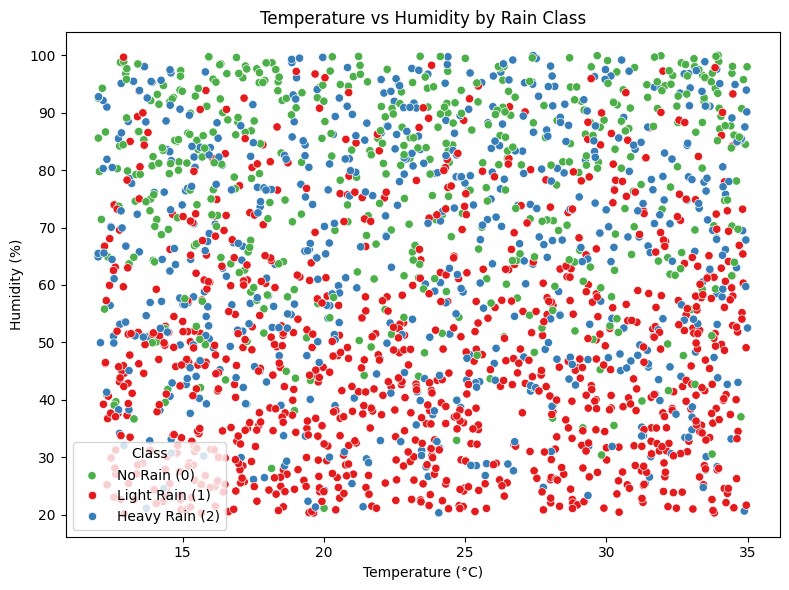

In [17]:
# Plot 1: Temperature vs Humidity coloured by class

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Temperature",
    y="Humidity",
    hue="Label",
    palette="Set1"
)
plt.title("Temperature vs Humidity by Rain Class")
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.legend(title="Class", labels=["No Rain (0)", "Light Rain (1)", "Heavy Rain (2)"])
plt.tight_layout()
plt.show()


/tmp/ipython-input-1628163892.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


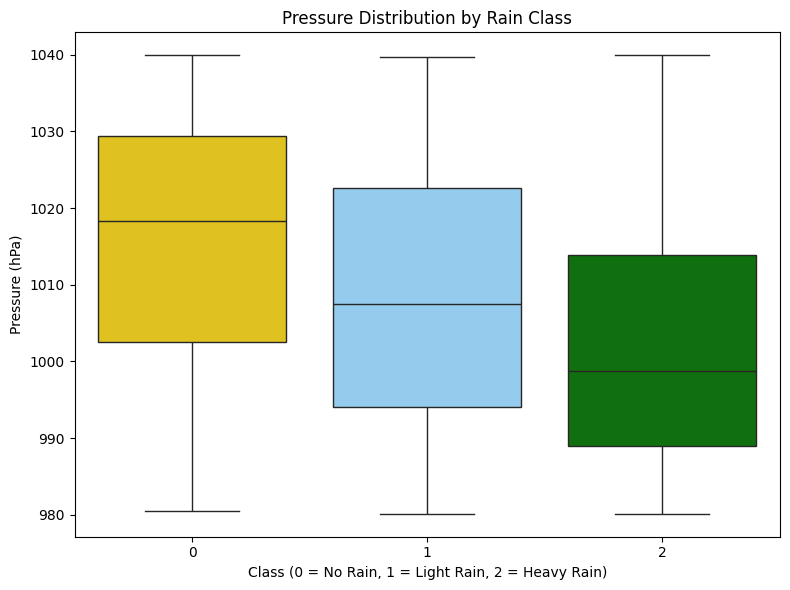

In [18]:
# Plot 2: Pressure distribution by class (boxplot)

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df,
    x="Label",
    y="Pressure",
    palette = ["#FFD700", "#87CEFA", "#008000"]
)
plt.title("Pressure Distribution by Rain Class")
plt.xlabel("Class (0 = No Rain, 1 = Light Rain, 2 = Heavy Rain)")
plt.ylabel("Pressure (hPa)")
plt.tight_layout()
plt.show()


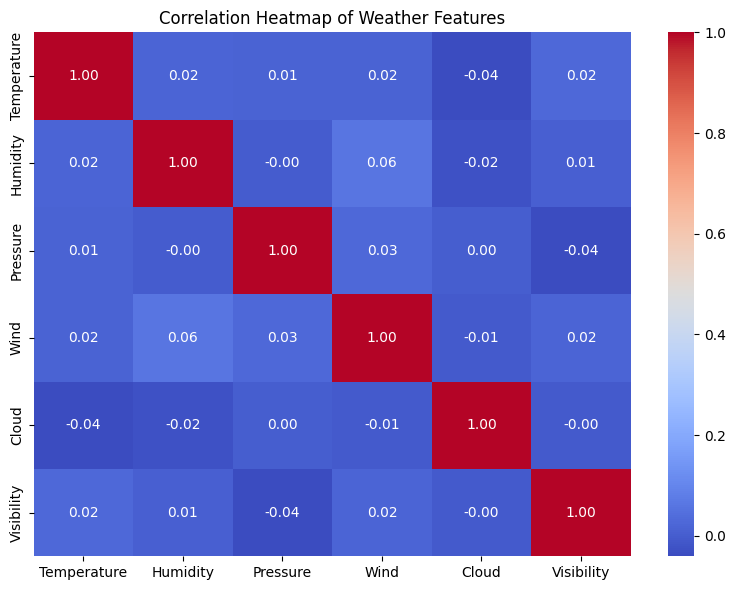

In [19]:
# Plot 3: Correlation heatmap of weather features

plt.figure(figsize=(8, 6))
corr = df.drop(columns=["Label"]).corr()
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap of Weather Features")
plt.tight_layout()
plt.show()


## 4. PCA: Projecting features into 2D space

Support Vector Machines work in high-dimensional feature spaces, but for visualisation we reduce the six weather features to **two principal components (PC1, PC2)** using Principal Component Analysis (PCA).

This allows us to plot decision boundaries for different kernels in 2D.


Explained variance ratio by the two principal components:
[0.18200876 0.17340728]


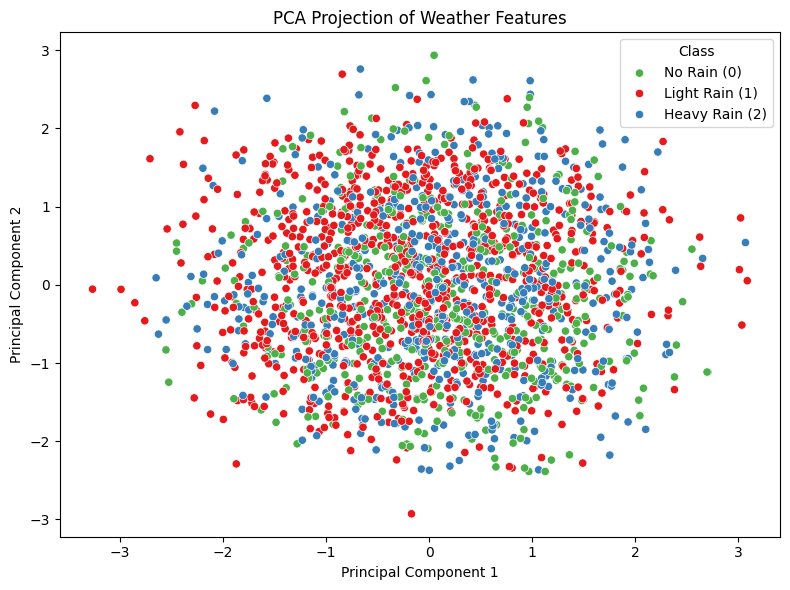

In [20]:
# Separate features (X) and target (y)
X = df.drop(columns=["Label"]).values
y = df["Label"].values

# Standardise features before applying PCA and SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 principal components for visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio by the two principal components:")
print(pca.explained_variance_ratio_)

# Create a DataFrame with PCA components for easier plotting
pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Label": y
})

# Plot PCA scatter by class
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Label",
    palette="Set1"
)
plt.title("PCA Projection of Weather Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", labels=["No Rain (0)", "Light Rain (1)", "Heavy Rain (2)"])
plt.tight_layout()
plt.show()


## 5. Training SVM models (Linear vs RBF)

We now train two SVM classifiers on the PCA-transformed features:

- **Linear SVM**  
- **RBF SVM** (Radial Basis Function kernel)

Both are evaluated on a hold-out test set.


In [21]:
# Split PCA-transformed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=seed, stratify=y
)

# Create and train a Linear SVM classifier
linear_svm = SVC(kernel="linear", decision_function_shape="ovr", random_state=seed)
linear_svm.fit(X_train, y_train)

# Predict on the test set
linear_pred = linear_svm.predict(X_test)
linear_acc = accuracy_score(y_test, linear_pred)

print(f"Linear SVM accuracy on test set: {linear_acc:.4f}")
print("\nClassification report (Linear SVM):")
print(classification_report(y_test, linear_pred))


Linear SVM accuracy on test set: 0.4500

Classification report (Linear SVM):
              precision    recall  f1-score   support

           0       0.45      1.00      0.62       180
           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00       100

    accuracy                           0.45       400
   macro avg       0.15      0.33      0.21       400
weighted avg       0.20      0.45      0.28       400



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Create and train an RBF SVM classifier
rbf_svm = SVC(kernel="rbf", gamma="scale", decision_function_shape="ovr", random_state=seed)
rbf_svm.fit(X_train, y_train)

# Predict on the test set
rbf_pred = rbf_svm.predict(X_test)
rbf_acc = accuracy_score(y_test, rbf_pred)

print(f"RBF SVM accuracy on test set: {rbf_acc:.4f}")
print("\nClassification report (RBF SVM):")
print(classification_report(y_test, rbf_pred))


RBF SVM accuracy on test set: 0.4725

Classification report (RBF SVM):
              precision    recall  f1-score   support

           0       0.47      0.94      0.63       180
           1       0.41      0.06      0.10       120
           2       0.48      0.13      0.20       100

    accuracy                           0.47       400
   macro avg       0.46      0.38      0.31       400
weighted avg       0.46      0.47      0.37       400



## 6. Visualising decision boundaries

Using the PCA representation, we plot the decision boundaries learned by:

- Linear SVM  
- RBF SVM  

These plots help us visually compare how each kernel separates the three weather classes.


In [23]:
# Helper function to plot decision boundaries in PCA space

def plot_decision_boundary(model, X, y, title):
    """Plot the decision boundary for a trained SVM model in 2D.

    Parameters
    ----------
    model : sklearn.svm.SVC
        Trained SVM classifier.
    X : array-like of shape (n_samples, 2)
        Input features (PCA components).
    y : array-like of shape (n_samples,)
        Target class labels.
    title : str
        Title for the plot.
    """
    # Create a mesh grid that covers the range of the PCA components
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    # Predict class for each point in the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision regions and the training data points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap="Pastel2", alpha=0.8)
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=y,
        palette="Set1",
        s=25,
        edgecolor="k",
        linewidth=0.3
    )
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Class", labels=["No Rain (0)", "Light Rain (1)", "Heavy Rain (2)"])
    plt.tight_layout()
    plt.show()


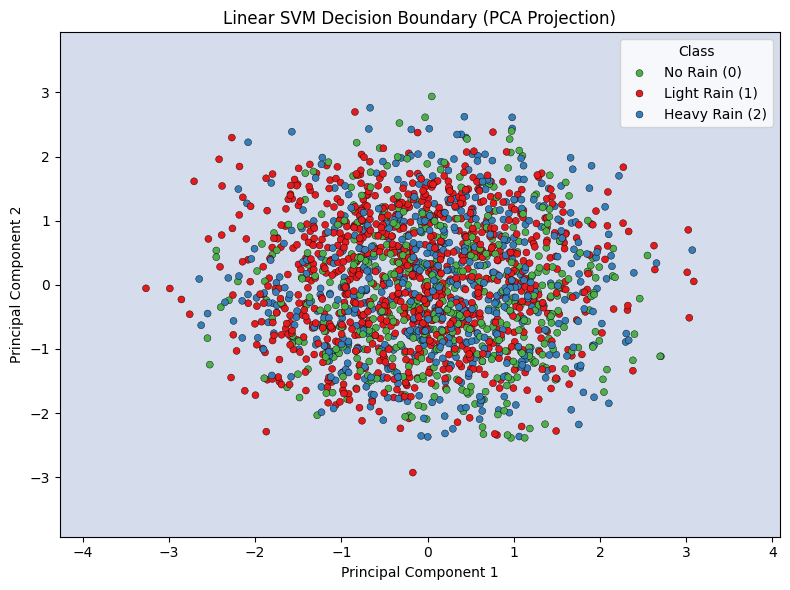

In [24]:
# Plot 5: Decision boundary for Linear SVM in PCA space

plot_decision_boundary(
    linear_svm,
    X_pca,
    y,
    "Linear SVM Decision Boundary (PCA Projection)"
)


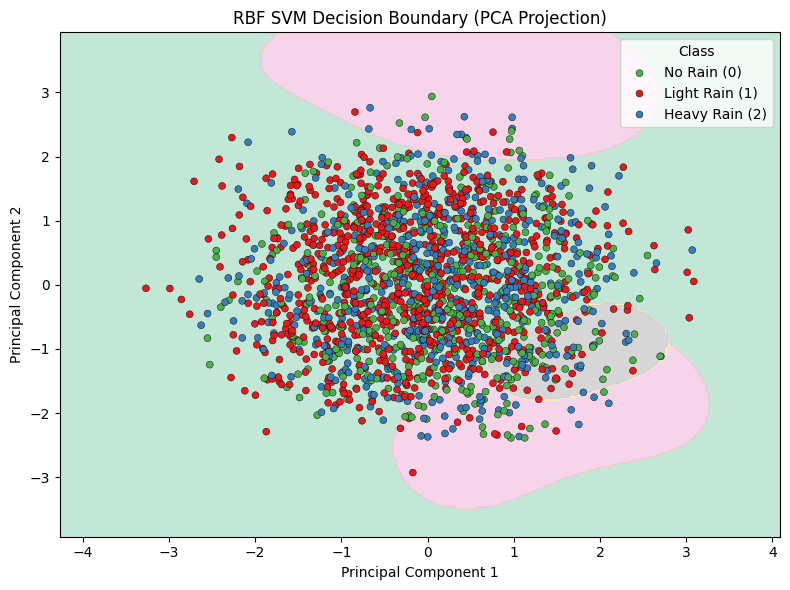

In [25]:
# Plot 6: Decision boundary for RBF SVM in PCA space

plot_decision_boundary(
    rbf_svm,
    X_pca,
    y,
    "RBF SVM Decision Boundary (PCA Projection)"
)


## 7. Accuracy comparison

Finally, we compare the classification accuracy of the Linear and RBF SVM models on the test set.


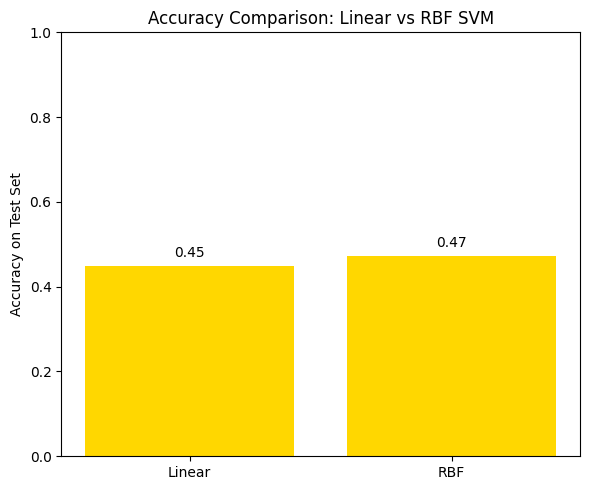

In [26]:
# Compare accuracies of Linear and RBF SVM models

models = ["Linear", "RBF"]
accuracies = [linear_acc, rbf_acc]

plt.figure(figsize=(6, 5))
plt.bar(models, accuracies, color="gold")
plt.ylim(0, 1)
plt.title("Accuracy Comparison: Linear vs RBF SVM")
plt.ylabel("Accuracy on Test Set")
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()
